In [2]:
from sotodlib import core
import numpy as np
import so3g
from scipy.optimize import curve_fit
import ephem
from datetime import datetime
from so3g.proj import coords, quat
from astropy.table import Table
import re, os, pickle
import matplotlib.pyplot as plt



In [3]:
def gaussian2d(xieta, a, xi0, eta0, fwhm_xi, fwhm_eta, phi):
    xi, eta = xieta
    xi_rot = xi*np.cos(phi) - eta*np.sin(phi)
    eta_rot = xi*np.sin(phi) + eta*np.cos(phi)
    factor = 2*np.sqrt(2*np.log(2))
    xi_coef = -0.5 * (xi_rot-xi0)**2/(fwhm_xi/factor)**2
    eta_coef = -0.5 * (eta_rot-eta0)**2/(fwhm_eta/factor)**2
    return(a*np.exp(xi_coef+eta_coef))


In [4]:
#Following two functions courtousy of Scipy cookbook

def gaussian(scale,y_offset, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: y_offset + scale*np.exp(
                -(((x-center_x)/width_x)**2+((y-center_y)/width_y)**2)/2)


def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    arr += gaussian(*args[0:6])(x,y)
    return arr


Starting SAT Beams


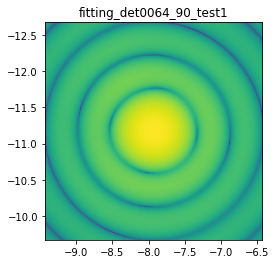

In [5]:
print("Starting SAT Beams")
name = 'fitting_det0064_90_test1'
path = '/home/jorlo/dev/gaussian_beams/'
sat_beam = pickle.load(open(path + name + '.pkl', 'rb'), encoding = 'bytes')

data = sat_beam[b'data']

X, Y = sat_beam[b'mesh'][0], sat_beam[b'mesh'][1]

plt.imshow(np.log(data), extent = [np.amin(X), np.amax(X),  np.amax(Y), np.amin(Y)])
plt.title(name)
plt.savefig(name + "_beam.pdf")
plt.show()


In [6]:
max_index = np.where(data==np.amax(data))

x0 = X[max_index]
y0 = Y[max_index]


In [7]:
p0 = [np.amax(data), -1,x0, y0, .5,.5]
xdata = np.vstack((X.ravel(), Y.ravel()))

popt, pcov = curve_fit(_gaussian, xdata, data.ravel(),p0)
print(popt)


[  8.03922740e+02   9.70325143e-01  -7.93350161e+00  -1.11729140e+01
   1.99074908e-01   1.95726535e-01]


(1001, 1001)


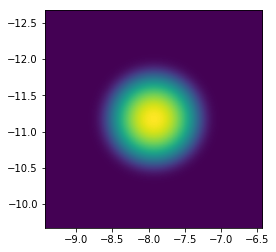

In [8]:
#Fit Plot
x = np.linspace(np.amin(X), np.amax(X), 1001)
y = np.linspace(np.amin(Y), np.amax(Y), 1001)
y = y[:, np.newaxis]
gaus2 = gaussian(*popt[0:6])(x,y)
print(gaus2.shape)
plt.imshow(np.log(gaus2), extent = [np.amin(X), np.amax(X),  np.amax(Y), np.amin(Y)])
plt.savefig('../plots/'+name+'t_gaus.pdf')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


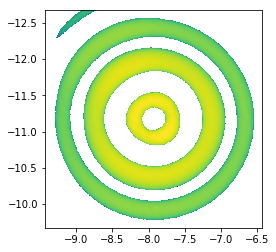

In [9]:
#2D Residual Plots
res2 = data - gaus2
plt.imshow(np.log(res2), extent = [np.amin(X), np.amax(X),  np.amax(Y), np.amin(Y)])
plt.savefig('../plots/'+ name + '_residual.pdf')
plt.show()


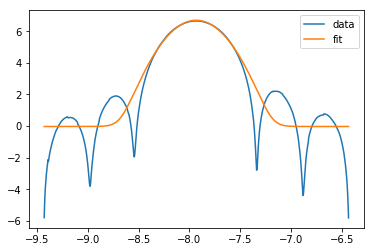

In [10]:
#Fit and Data Slice
yslice_data = data[max_index[1]][0]
yslice_fit = gaus2[max_index[1]][0]
plt.plot(x,np.log(yslice_data), label = "data")
plt.plot(x,np.log(yslice_fit), label = "fit")
plt.legend()
plt.savefig('../plots/'+ name +"slice_fit_data.pdf")
plt.show()


In [11]:
#LAT Fitting
lat_path = '/home/jorlo/dev/pwg-scripts/pwg-bcp/2020_03_06_LAT_UHF_Beams/'
lat_name = 'LAT_beam_270GHz_center_tube.p'

lat_beam  = pickle.load(open(lat_path + lat_name, 'rb'), encoding = 'bytes')


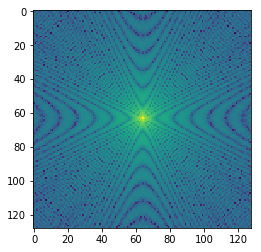

In [12]:
lat_data = lat_beam['data']
plt.imshow(np.log(lat_data))
plt.show()

In [13]:
lat_beam

{'data': array([[  2.35500000e-07,   1.62200000e-08,   2.25400000e-07, ...,
           8.33500000e-08,   2.25400000e-07,   1.62200000e-08],
        [  5.84100000e-09,   2.38300000e-07,   1.85100000e-07, ...,
           2.35300000e-08,   1.85100000e-07,   2.38300000e-07],
        [  1.56000000e-07,   8.69800000e-08,   2.38900000e-08, ...,
           3.22300000e-07,   2.38900000e-08,   8.69800000e-08],
        ..., 
        [  4.98000000e-09,   2.38300000e-07,   1.83000000e-07, ...,
           2.47700000e-08,   1.83000000e-07,   2.38300000e-07],
        [  2.31900000e-07,   1.70700000e-08,   2.28000000e-07, ...,
           8.16800000e-08,   2.28000000e-07,   1.70700000e-08],
        [  5.53900000e-07,   2.20100000e-07,   4.61100000e-09, ...,
           1.66600000e-07,   4.61100000e-09,   2.20100000e-07]]),
 'size': [[1.28, 0.01], [128, 1]]}

In [14]:
len(lat_beam['data'][0])

128

In [15]:
sat_beam

{b'data': array([[ 0.28518933,  0.27773014,  0.2715936 , ...,  0.34054178,
          0.34412417,  0.34756872],
        [ 0.2777417 ,  0.27024236,  0.26273671, ...,  0.33469751,
          0.34047222,  0.3440541 ],
        [ 0.27029541,  0.26276261,  0.25522906, ...,  0.33090842,
          0.33669534,  0.34041199],
        ..., 
        [ 0.34258869,  0.33872679,  0.3347272 , ...,  0.31618789,
          0.32179976,  0.3273029 ],
        [ 0.34630948,  0.34257928,  0.33870986, ...,  0.3217828 ,
          0.32730615,  0.33271673],
        [ 0.34989697,  0.34630021,  0.342563  , ...,  0.32728142,
          0.3327117 ,  0.33802509]], dtype=float32),
 b'mesh': (array([[-9.43198, -9.42898, -9.42598, ..., -6.43798, -6.43498, -6.43198],
         [-9.43198, -9.42898, -9.42598, ..., -6.43798, -6.43498, -6.43198],
         [-9.43198, -9.42898, -9.42598, ..., -6.43798, -6.43498, -6.43198],
         ..., 
         [-9.43198, -9.42898, -9.42598, ..., -6.43798, -6.43498, -6.43198],
         [-9.43198, 